 # Práctica  4.
 ----
  
  Universidad : UTEC \\
  Curso       : Inteligencia Artificial \\
  Profesor    : Cristian López Del Alamo \\
  Tema        : Soft SVM \\
  

 ----

 Nombres y  Apellidos de Integrantes (Añada porcentaje de participación de cada miembro del equipo): Concluido
 - Integrante 1: Gabriel Romero (100%)
 - Integrante 2: Matias Maravi (100%)
 - Integrante 3: Rodo Vilcarromero (100%)
 - Integrante 4: Fabian Alvarado (100%)


*Una vez concluya la práctica debe subir el link de su colab a este  [Drive](https://docs.google.com/spreadsheets/d/1XCxGVmf8g29C7RZSPOqxvZHjjRZg45LHWR8mkZOfS1o/edit?usp=sharing)*


# Librerias

In [2]:
import math
import pandas as pd
import numpy as np
# import torch
import matplotlib.pyplot as plt
# import tensorflow as tf


# Base de datos
1. Descarge en su disco esta Base de Datos:
[Download](https://docs.google.com/spreadsheets/d/15-E3kiLJ6bCyXuJvSmxYAp2QYMkPX2QlQ597fAsPYy8/edit?usp=sharing).
2. Para cargar la base de datos de su disco duro utilize el siguiente comando.
from google.colab import files
uploaded = files.upload()
3. Cargamos 70% de los datos para entrenamiento y el resto para testing
4. Solo estamos tomando 2 características, pero usted debe usar métodos de reducción de la dimensionalidad como PCA.


In [3]:
def normalize_data(train_data, test_data):
    min_values = np.min(train_data, axis=0)
    max_values = np.max(train_data, axis=0)

    train_normalized = (train_data - min_values) / (max_values - min_values)
    test_normalized = (test_data - min_values) / (max_values - min_values)

    return train_normalized, test_normalized


In [4]:

iris = pd.read_csv("iris.csv")

# Cambiamos todos los setosas a 1 y los demás a -1
iris['label'] = np.where(iris['variety'] == 'Setosa', 1, -1)

# 70% para entrenamiento y el resto para testing
iris_train = iris.sample(frac=0.7)
iris_test = iris[~iris.index.isin(iris_train.index)]

# Solo tomamos 2 características para poder ser visualizado (Noda: En realidad debemos reducir la dimensionalidad por ejemplo con componentes principales)

iris_train_x = iris_train[['sepal.length', 'sepal.width']].to_numpy()
iris_train_y = iris_train['label'].to_numpy()

iris_test_x = iris_test[['sepal.length', 'sepal.width']].to_numpy()
iris_test_y = iris_test['label'].to_numpy()


"""
iris = pd.read_csv("DataSet_Iris_2_Clases.csv")

iris['label'] = np.where(iris['variety'] == 'Setosa', 1, -1)

iris_train = iris.sample(frac=0.7, random_state=42)
iris_test = iris.drop(iris_train.index)

train_min_values = iris_train[['sepal.length', 'sepal.width', 'petal.length', 'petal.width']].min()
train_max_values = iris_train[['sepal.length', 'sepal.width', 'petal.length', 'petal.width']].max()

iris_train[['sepal.length', 'sepal.width', 'petal.length', 'petal.width']] = (iris_train[['sepal.length', 'sepal.width', 'petal.length', 'petal.width']] - train_min_values) / (train_max_values - train_min_values)
iris_test.loc[:, ['sepal.length', 'sepal.width', 'petal.length', 'petal.width']] = (iris_test[['sepal.length', 'sepal.width', 'petal.length', 'petal.width']] - train_min_values) / (train_max_values - train_min_values)

iris_train_x = iris_train[['sepal.length', 'sepal.width']].to_numpy()
iris_train_y = iris_train['label'].to_numpy()
iris_test_x = iris_test[['sepal.length', 'sepal.width']].to_numpy()
iris_test_y = iris_test['label'].to_numpy()
"""

'\niris = pd.read_csv("DataSet_Iris_2_Clases.csv")\n\niris[\'label\'] = np.where(iris[\'variety\'] == \'Setosa\', 1, -1)\n\niris_train = iris.sample(frac=0.7, random_state=42)\niris_test = iris.drop(iris_train.index)\n\ntrain_min_values = iris_train[[\'sepal.length\', \'sepal.width\', \'petal.length\', \'petal.width\']].min()\ntrain_max_values = iris_train[[\'sepal.length\', \'sepal.width\', \'petal.length\', \'petal.width\']].max()\n\niris_train[[\'sepal.length\', \'sepal.width\', \'petal.length\', \'petal.width\']] = (iris_train[[\'sepal.length\', \'sepal.width\', \'petal.length\', \'petal.width\']] - train_min_values) / (train_max_values - train_min_values)\niris_test.loc[:, [\'sepal.length\', \'sepal.width\', \'petal.length\', \'petal.width\']] = (iris_test[[\'sepal.length\', \'sepal.width\', \'petal.length\', \'petal.width\']] - train_min_values) / (train_max_values - train_min_values)\n\niris_train_x = iris_train[[\'sepal.length\', \'sepal.width\']].to_numpy()\niris_train_y = iri

# **Soft SVM**

- Implementar todas las funciones para que este código sea funcional

In [5]:
def loss(y, x, w, bias, c):
  m = np.maximum(0,1-y*(x @ w+bias))
  return 0.5*np.dot(w,w)+c*np.sum(m)

In [6]:
def grad(y, x, w, bias, c):
    margin = y * (np.dot(x, w) + bias)
    incorrect_classified = (margin < 1).astype(int)

    grad_w = w - c * np.dot(x.T, (incorrect_classified * y))
    grad_b = -c * np.sum(incorrect_classified * y)

    return grad_w, grad_b

In [7]:
def update(w, b, grad, alpha):
  w -= grad[0] * alpha
  b -= grad[1] * alpha
  return w,b

In [8]:
def h(x, w, b):
    return np.dot(x, w) + b

# Entrenamiento

In [9]:
def train(x,y,num_epochs,c=10, alpha=0.00001):
  w = np.random.rand(iris_train_x.shape[1])
  b = np.random.random()

  loss_function = []
  step = num_epochs//10
  for epoch in range(num_epochs):
    loss_value = loss(iris_train_y, iris_train_x, w, b, c)
    loss_function.append(loss_value)
    if epoch % step == 0:
      print(f'Epoch {epoch}, loss {loss_value}')
    for idx, x_i in enumerate(iris_train_x):
      grad_values = grad(iris_train_y[idx], x_i, w, b, c)
      w, b = update(w, b, grad_values, alpha)
  return w,b

  plt.plot(range(num_epochs), loss_function, label='Función de pérdida')
  plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")

# Funciones par graficar

In [10]:
def plane_intersect(a, b):
    a_vec, b_vec = np.array(a[:3]), np.array(b[:3])
    aXb_vec = np.cross(a_vec, b_vec)
    A = np.array([a_vec, b_vec, aXb_vec])
    d = np.array([-a[3], -b[3], 0.]).reshape(3,1)
    p_inter = np.linalg.solve(A, d).T
    return p_inter[0], (p_inter + aXb_vec)[0]

In [11]:
def test(x,w,b,y):
  v = np.dot(x,w) + b
  m = []
  for i in v:
    if(i>0):
      m.append(1)
    else:
      m.append(-1)
  print("Numero de aciertos: ", np.sum(m == y))
  print("Numero de errores: ", np.sum(m != y))

Epoch 0, loss 1968.624055574604
Epoch 100, loss 0.06537415235886865
Epoch 200, loss 0.05931270808851318
Epoch 300, loss 0.054037796665255766
Epoch 400, loss 0.04944738621964408
Epoch 500, loss 0.04545269421055145
Epoch 600, loss 0.041976689993394746
Epoch 700, loss 0.03895217639209783
Epoch 800, loss 0.04167170118312707
Epoch 900, loss 0.03459609922448343
Numero de aciertos:  30
Numero de errores:  0


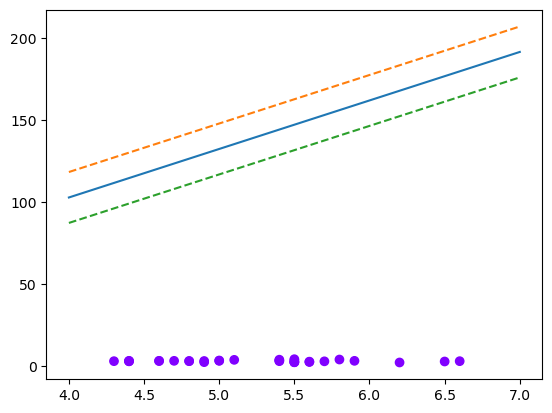

In [12]:
import matplotlib.cm as cm
w,b = train(iris_train_x,iris_train_y,1000)
iris_y_ = h(iris_test_x, w, b)
iris_y_pred = np.sign(iris_y_)

x_1, x_2 = plane_intersect(list(w)+[0,b], [0,0,1,0])
m = (x_2[1]-x_1[1])/(x_2[0]-x_1[0])
c = -m*x_1[0] + x_1[1]

d = 1/np.linalg.norm(w)
c_p = -m*(x_1[0] + d*math.sqrt(1/(1+m**2))) + x_1[1] + m*d*math.sqrt(1/(1+m**2))

plt.plot(range(4,8), [m*x_i + c for x_i in range(4,8)])
plt.plot(range(4,8), [m*x_i + c - c_p for x_i in range(4,8)], '--')
plt.plot(range(4,8), [m*x_i + c + c_p for x_i in range(4,8)], '--')
plt.scatter(iris_test_x[:,0], iris_test_x[:,1], color=cm.rainbow(iris_y_pred + 1))

test(iris_test_x,w,b,iris_test_y)

In [13]:
print("Hello World!")

Hello World!
